# Sub-Task 2 (Taxi Problem):

In [1]:
#Imports the necessary libraries 
import gym
import numpy as np
import sys
import random
import math
from time import sleep
from IPython.display import clear_output
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import itertools
import networkx

In [2]:
"""
This code is adapted from the taxi problem tutorial at:

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

Added a graph to visualize reward data

All credit goes to the authors.

"""

'\nThis code is adapted from the taxi problem tutorial at:\n\nhttps://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/\n\nAdded a graph to visualize reward data\n\nAll credit goes to the authors.\n\n'

### Environment Setup

In [3]:
#Creates the Taxi environment via gym
env = gym.make('Taxi-v3').env

In [5]:
#Resets environment to a new, random state
env.reset()

369

In [6]:
#Renders one frame of the environment for visualization 
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [7]:
# reset environment to a new, random state
env.reset()
#Renders one frame of the environment for visualization
env.render()

#Prints the size of the action space
print("Action Space {}".format(env.action_space))
#Prints the size of the state space
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [8]:
#(taxi row, taxi column, passenger index, destination index)
state = env.encode(3, 1, 2, 0)
print("State:", state)

env.s = state
env.render()


State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [9]:
#Creates a reward table with # of states as rows # of actions as columns
#states x actions matrix
#0-5 represent taxi actions (south, north, east, west, pickup, dropoff)
#1.0 is environment probability at state 328
#The nextstate is the state we would be in if we take the action at this index of the dict
#Movement actions have -1 reward at state 328
#Pickup/dropoff actions have -10 reward at state 328
#Successful drop off is represented by T or F
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

### Solving the Environment Without Reinforcement Learning

In [13]:
#Solving the Environment without RL
#Set environment to illustration's state
env.s = 328  

epochs = 0
penalties, reward = 0, 0
episode_reward = 0

frames = [] # for animation
rewards_array = [] #for comparison w/qlearning 
penalties_array = []

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    episode_reward += reward

    if reward == -10:
        penalties += 1
    rewards_array.append(episode_reward)
    penalties_array.append(penalties)
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


Timesteps taken: 7421
Penalties incurred: 2405


In [14]:
#Prints the reward table of the current state, states x actions matrix 
#States = rows
#Number of actions = columns 
env.P[state]

{0: [(1.0, 100, -1, False)],
 1: [(1.0, 0, -1, False)],
 2: [(1.0, 20, -1, False)],
 3: [(1.0, 0, -1, False)],
 4: [(1.0, 16, -1, False)],
 5: [(1.0, 0, -10, False)]}

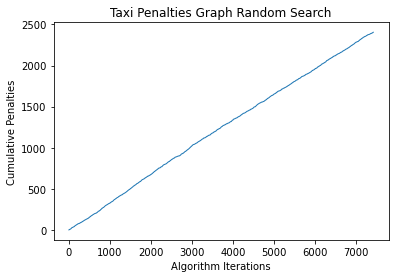

In [17]:
#Creates a Graph of Cumulative Penalties Data
plt.title("Taxi Penalties Graph Random Search")
plt.plot(penalties_array, linewidth=1)
plt.ylabel('Cumulative Penalties')
plt.xlabel('Algorithm Iterations')
plt.show()

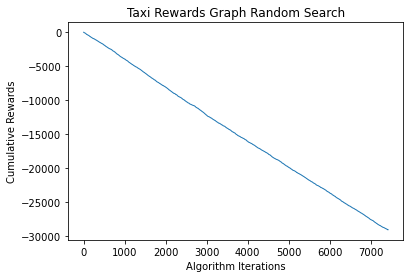

In [18]:
#Creates a Graph of Cumulative Penalties Data
plt.title("Taxi Rewards Graph Random Search")
plt.plot(rewards_array, linewidth=1)
plt.ylabel('Cumulative Rewards')
plt.xlabel('Algorithm Iterations')
plt.show()

In [130]:
#Visualisation in real time of the Taxi environment & actions
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 124
State: 125
Action: 2
Reward: -1


KeyboardInterrupt: 

### Q-Learning

In [20]:
#Initializes the q-table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [21]:
%%time
"""Training the agent"""

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1
        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: total: 1min 5s
Wall time: 59.7 s


In [22]:
#Displays the q-table for state 328
q_table[328]

array([ -2.39829006,  -2.27325184,  -2.41054619,  -2.35773064,
       -10.80424811, -10.20063564])

### Evaluate agent's performance after Q-learning

In [23]:
total_epochs, total_penalties = 0, 0
episodes = 300

penalties_array = []
rewards_array = []

for _ in range(episodes):
    state = env.reset()
    episode_reward = 0
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)
        episode_reward += reward

        if reward == -10:
            penalties += 1

        epochs += 1
        penalties_array.append(penalties)
        rewards_array.append(episode_reward)

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 300 episodes:
Average timesteps per episode: 13.083333333333334
Average penalties per episode: 0.0


In [24]:
env.P[state]

{0: [(1.0, 185, -1, False)],
 1: [(1.0, 85, -1, False)],
 2: [(1.0, 85, -1, False)],
 3: [(1.0, 65, -1, False)],
 4: [(1.0, 97, -1, False)],
 5: [(1.0, 85, -10, False)]}

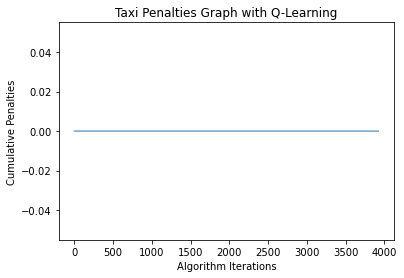

In [25]:
#Creates a Graph of Cumulative Penalties Data
plt.title("Taxi Penalties Graph with Q-Learning")
plt.plot(penalties_array, linewidth=1)
plt.ylabel('Cumulative Penalties')
plt.xlabel('Algorithm Iterations')
plt.show()

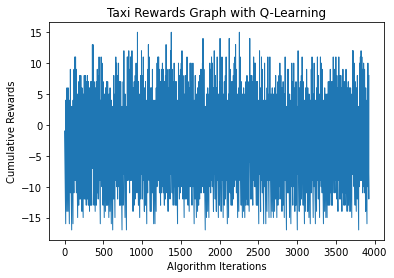

In [26]:
#Creates a Graph of Rewards Data 
plt.title("Taxi Rewards Graph with Q-Learning")
plt.plot(rewards_array, linewidth=1)
plt.ylabel('Cumulative Rewards')
plt.xlabel('Algorithm Iterations')
plt.show()